In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import datetime
from datetime import date
from fbprophet import Prophet
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
from scipy.signal import savgol_filter
from __future__ import print_function

In [2]:
# choose file
filename = 'data/Daylight_saving_time.csv'

In [3]:
# read in data
filepath = os.path.join(os.path.dirname(os.path.realpath('__file__')), filename)
df = pd.read_csv(filepath)
print("Found {n} observations but {m} were zero.".format(n=len(df),m=len(df[df.y==0])))

# recode zeros as NaN
df = df.replace(0, np.nan)

#and drop
#df = df.dropna()
# format datestamp column
df.ds = pd.to_datetime(df.ds)

# log values
df.yOri = df.y
df.y = np.log(df.y)


Found 2920 observations but 35 were zero.


In [4]:
# special events ("holidays")

# clocks move forward
springforward = pd.DataFrame({
  'holiday': 'springforward',
  'ds': pd.to_datetime(['2008-03-09', '2009-03-08',
                        '2010-03-14', '2011-03-13',
                        '2012-03-11', '2013-03-10',
                        '2014-03-09', '2015-03-08']),
  'lower_window': -14,
  'upper_window': 14,
})

# clocks move backward
fallback = pd.DataFrame({
  'holiday': 'fallback',
  'ds': pd.to_datetime(['2008-11-02', '2009-11-01',
                        '2010-11-07', '2011-11-06',
                        '2012-11-03', '2013-11-03',
                        '2014-11-02', '2015-11-01']),
  'lower_window': -14,
  'upper_window': 0
})

# dates when major changes to DST were discussed/implemented/dismissed
news = pd.DataFrame({
  'holiday': 'news',
  'ds': pd.to_datetime(['2010-04-14', '2010-09-12',
                        '2011-02-08', '2011-06-15',
                        '2011-09-15', '2011-09-20',
                        '2012-11-05', '2013-07-08',
                        '2014-07-22', '2015-10-25']),
  'lower_window': -7,
  'upper_window': 21
})

holidays = pd.concat((springforward, fallback, news))
print(holidays)

          ds        holiday  lower_window  upper_window
0 2008-03-09  springforward           -14            14
1 2009-03-08  springforward           -14            14
2 2010-03-14  springforward           -14            14
3 2011-03-13  springforward           -14            14
4 2012-03-11  springforward           -14            14
5 2013-03-10  springforward           -14            14
6 2014-03-09  springforward           -14            14
7 2015-03-08  springforward           -14            14
0 2008-11-02       fallback           -14             0
1 2009-11-01       fallback           -14             0
2 2010-11-07       fallback           -14             0
3 2011-11-06       fallback           -14             0
4 2012-11-03       fallback           -14             0
5 2013-11-03       fallback           -14             0
6 2014-11-02       fallback           -14             0
7 2015-11-01       fallback           -14             0
0 2010-04-14           news            -7       

**List of DST-Related News**

2010, April 14: Referendum bill submitted to vote on introducing daylight saving to South East Queensland.

2010, September 12: Israel's scheduled date of return to winter time, which was unusually early due to differences between the Hebrew and solar calendar.

2011, February 8: Russia declared it would stay in DST all-year long.

2011, June 15: DST bill was defeated in the Queensland parliament

2011, September 15: Belarus declared it would stay in DST all-year long.

2011, September 20: Ukrainian voted to stay in DST all-year long, though later in the year on October 18, this plan was canceled and the country returned to Eastern European Time as scheduled.

2012, November 5: Israel approved bill to extend IDT (Israel Daylight Time).

2013, July 8: Israel approved bill to extend IDT even further. The move was controversial as it forced people to pray before sunrise.

2014, July 22: Russia moved back one hour, reverting to Standard Time.

2015, October 25: Turkey was due to revert to Standard Time, but the government postponed the change due to impending polls, causing confusion.

In [5]:
# forecast horizon
H = 365

# frequency of simulated forecasts
h = int(H/2)

# tuning and validation: simulated historical forecast

# for storing forecast results and cutoffdates
results = pd.DataFrame()
cutoff = []

# run forecast simulations
i = 0
while (len(df)-i > 3*H): 

    # define training data
    train = df.iloc[i:(i+(3*H))] # use 3 periods of data for training

    # fit time series model
    m = Prophet(interval_width=0.95,
                changepoint_prior_scale=0.01, # default is 0.05, decreasing it makes trend more generalizable
                holidays=holidays,
                holidays_prior_scale=10, # default is 10, strength of the holiday components
                yearly_seasonality=True, # since daylight savings occur annually
                weekly_seasonality=True, # people conduct more searches on weekdays
                seasonality_prior_scale=10, # default is 10, larger values allow larger seasonal fluctuations
                # mcmc_samples=500 # to generate confidence intervals for seasonality and holiday components
               )
    m.fit(train);
    
    # future dates for which to make forecasts
    future = m.make_future_dataframe(periods=H)
    
    # make forecast
    forecast = m.predict(future)
    resultsH = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(H)
    
    # get actual values to compare with predicted values
    resultsH = df.merge(resultsH, how='right')
        
    # sort by increasing date
    resultsH = resultsH.sort_values(by='ds')
    
    # record cutoff dates
    cutoffDate = resultsH['ds'].iloc[0]
    cutoffDate = cutoffDate.strftime('%Y %b')
    cutoff = cutoff + [cutoffDate]
    
    # compile results
    results = pd.concat((results, resultsH))
    
    print ('Counting the days...', i)
    i = i + h

Counting the days... 0
Counting the days... 182
Counting the days... 364
Counting the days... 546
Counting the days... 728
Counting the days... 910
Counting the days... 1092
Counting the days... 1274
Counting the days... 1456
Counting the days... 1638
Counting the days... 1820


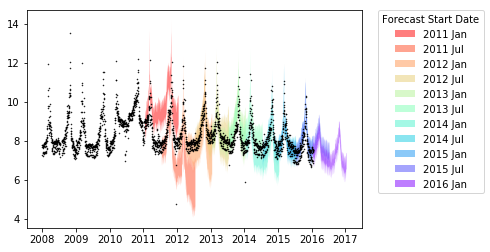

In [7]:
# number of simulated forecasts
ns = len(cutoff)

# color-code each simulation run
colors = cm.rainbow(np.linspace(1, 0, ns))

# plot simulated forecast results
plt.plot_date(df.ds, df.y, fmt='.', ms=1, c='k', label='')
i = 0
for s in range(ns):
    plt.fill_between(results.ds.values[i:(i+H)],
                     results.yhat_upper[i:(i+H)], results.yhat_lower[i:(i+H)],
                     facecolor=colors[s], alpha=0.5,
                     linewidth=0.0,
                     label=cutoff[s])
    i = i + H
# legend showing the start date of each forecast horizon
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
           title='Forecast Start Date')
plt.savefig('images/time-forecast.png', format='png', bbox_inches='tight', dpi=1000)
plt.show()

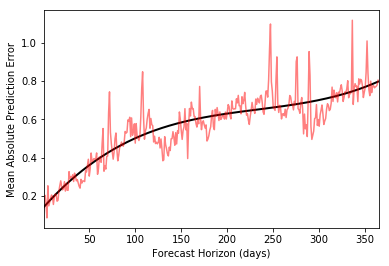

In [8]:
# prediction error
error = abs(results.yhat - results.y)
error = error.values.reshape(ns,H)

# average error with respect to forecast horizon
errorMean = np.nanmean(error, axis=0)

# smooth error trend
errorMeanSmooth = savgol_filter(errorMean, 365, 3)

# plot error along forecast horizon
plt.xlim([1,H])
plt.plot(range(H), errorMeanSmooth, c='k', lw=2)
plt.plot(range(H), errorMean, c='r', alpha=0.5)
plt.xlabel('Forecast Horizon (days)')
plt.ylabel('Mean Absolute Prediction Error')
plt.savefig('images/time-error.png', format='png', bbox_inches='tight', dpi=1000)
plt.show()

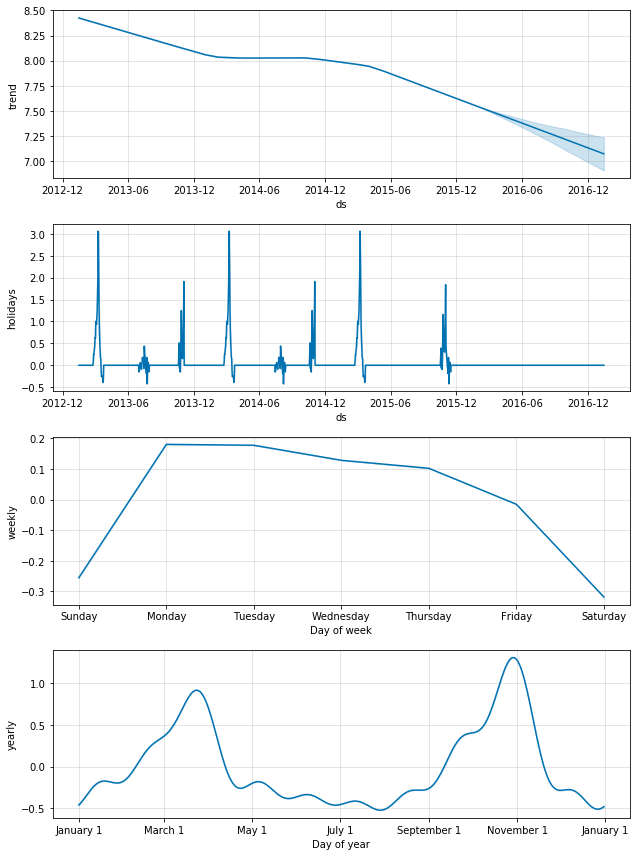

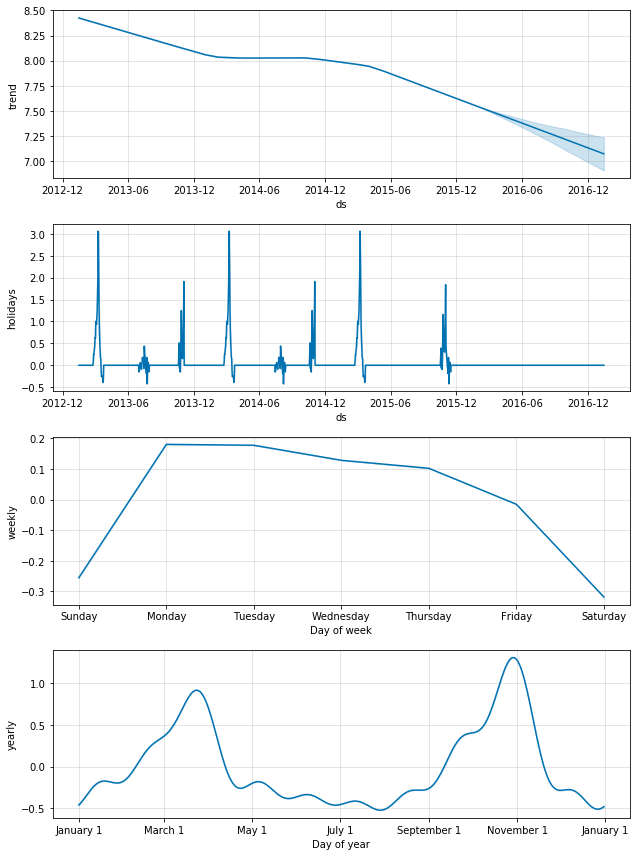

In [9]:
# component plots
m.plot_components(forecast)
compPlot = m.plot_components(forecast)
compPlot.savefig('images/time-components.png', format='png', bbox_inches='tight', dpi=1000)

In [10]:
# tuning and validation: simulated historical forecast

# for storing forecast results and cutoffdates
results2 = pd.DataFrame()
cutoff = []

# run forecast simulations
i = 0
while (len(df)-i > 3*H): 

    # define training data
    train = df[i:(i+(3*H))] # use 3 periods of data for training

    # fit time series model
    m = Prophet(interval_width=0.95,
                changepoint_prior_scale=10, # default is 0.05, decreasing it makes trend more generalizable
                holidays=holidays,
                holidays_prior_scale=10, # default is 10, strength of the holiday components
                yearly_seasonality=True, # since daylight savings occur annually
                weekly_seasonality=True, # people conduct more searches on weekdays
                seasonality_prior_scale=10, # default is 10, larger values allow larger seasonal fluctuations
                # mcmc_samples=500 # to generate confidence intervals for seasonality and holiday components
               )
    m.fit(train);
    
    # future dates for which to make forecasts
    future = m.make_future_dataframe(periods=H)
    
    # make forecast
    forecast = m.predict(future)
    results2H = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(H)
    
    # get actual values to compare with predicted values
    results2H = df.merge(results2H, how='right')
        
    # sort by increasing date
    results2H = results2H.sort_values(by='ds')
    
    # record cutoff dates
    cutoffDate = results2H['ds'].iloc[0]
    cutoffDate = cutoffDate.strftime('%Y %b')
    cutoff = cutoff + [cutoffDate]
    
    # compile results
    results2 = pd.concat((results2, results2H))
    
    print ('Counting the days...', i)
    i = i + h
    

Counting the days... 0
Counting the days... 182
Counting the days... 364
Counting the days... 546
Counting the days... 728
Counting the days... 910
Counting the days... 1092
Counting the days... 1274
Counting the days... 1456
Counting the days... 1638
Counting the days... 1820


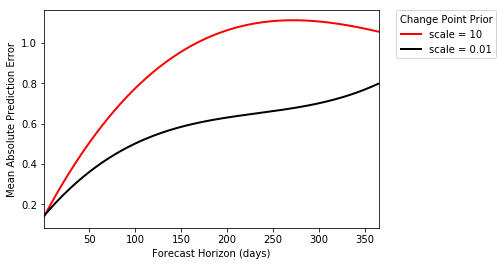

In [11]:
# prediction error
error2 = abs(results2.yhat - results2.y)
error2 = error2.values.reshape(ns,H)

# average error with respect to forecast horizon
errorMean2 = np.nanmean(error2, axis=0)

# smooth error trend
errorMeanSmooth2 = savgol_filter(errorMean2, 365, 3)

# plot error along forecast horizon
plt.xlim([1,H])
plt.plot(range(H), errorMeanSmooth2, c='r', lw=2, label='scale = 10')
plt.plot(range(H), errorMeanSmooth, c='k', lw=2, label='scale = 0.01')
plt.xlabel('Forecast Horizon (days)')
plt.ylabel('Mean Absolute Prediction Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
           title='Change Point Prior')
plt.savefig('images/time-errorCompare.png', format='png', bbox_inches='tight', dpi=1000)
plt.show()